### Comparison of `Leaky` (LIF) neuron vs. our custom `Funky` neuron (LIF neuron with threshold that randomly changes when a spike is fired). 

**NOTE:** This notebook requires a custom version of snnTorch with `Funky` neuron added, available at [https://github.com/calderast/snntorch]. The pull request detailing the exact functionality added to snnTorch is [here](https://github.com/calderast/snntorch/pull/1).

This notebook is adapted from [snnTorch Tutorial 3](https://github.com/jeshraghian/snntorch/blob/master/examples/tutorial_3_feedforward_snn.ipynb) and [snnTorch Tutorial 5](https://github.com/jeshraghian/snntorch/blob/master/examples/tutorial_5_FCN.ipynb).

In [10]:
# Imports
import numpy as np
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

### `Leaky` Neuron Model vs custom `Funky` Neuron Model in snnTorch

In [3]:
import snntorch as snn
from snntorch._neurons import Leaky, Funky

lif1 = Leaky(beta=0.8)
funky1 = Funky(beta=0.8, funkiness=0.05)

The Leaky neuron model is now stored in `lif1`, and the Funky neuron model stored in `funky1`.
 To use these neurons:

**Inputs**
* `cur_in`: each element of $W\times X[t]$ is sequentially passed as an input
* `mem`: the previous step membrane potential, $U[t-1]$, is also passed as input.

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U[t]$ of the present step

These all need to be of type `torch.Tensor`. Note that here, we assume the input current has already been weighted before passing into the `snn.Leaky` or `snn.Funky` neurons. 

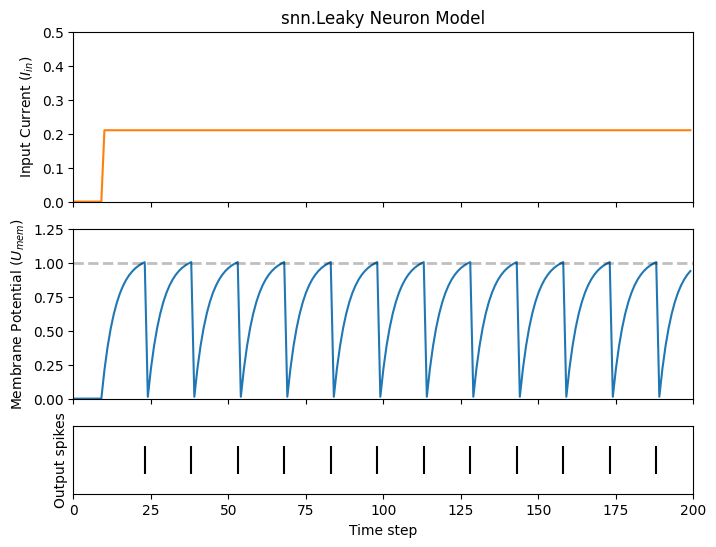

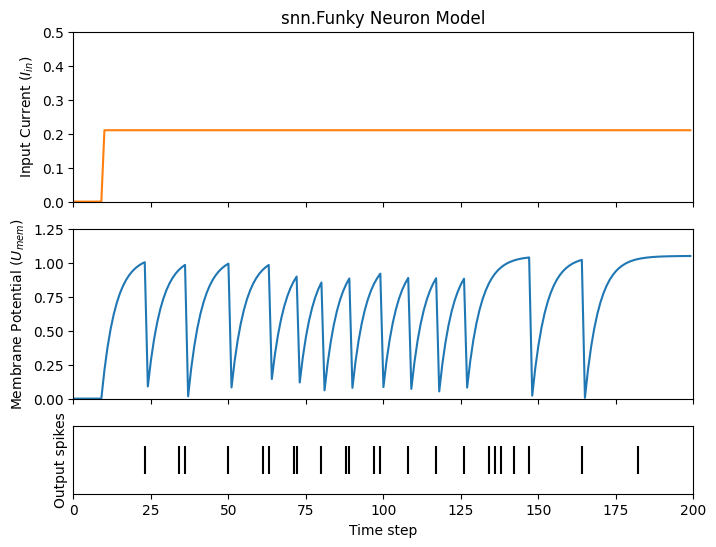

In [4]:
num_steps = 200

# Small step current input
w = 0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
# Set up for LIF
mem_lif = torch.zeros(1)
spk_lif = torch.zeros(1)
mem_lif_rec = []
spk_lif_rec = []
# Same but for funky
mem_funky = torch.zeros(1)
spk_funky = torch.zeros(1)
mem_funky_rec = []
spk_funky_rec = []

# Neuron simulation
for step in range(num_steps):
  # LIF
  spk_lif, mem_lif = lif1(cur_in[step], mem_lif)
  mem_lif_rec.append(mem_lif)
  spk_lif_rec.append(spk_lif)
  # Funky
  spk_funky, mem_funky = funky1(cur_in[step], mem_funky)
  mem_funky_rec.append(mem_funky)
  spk_funky_rec.append(spk_funky)

# Convert lists to tensors
mem_lif_rec = torch.stack(mem_lif_rec)
spk_lif_rec = torch.stack(spk_lif_rec)
mem_funky_rec = torch.stack(mem_funky_rec)
spk_funky_rec = torch.stack(spk_funky_rec)

plot_cur_mem_spk(cur_in, mem_lif_rec, spk_lif_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")
plot_cur_mem_spk(cur_in, mem_funky_rec, spk_funky_rec, ylim_max1=0.5,
                 title="snn.Funky Neuron Model")

Note that for the `Leaky` neuron, a consistent train of spikes is produced in response to a constant injected input current. For the `Funky` neuron, the constant input leads to a variable spike rate output, as the spike threshold is randomly modified each time the neuron fires.

# 3. A Feedforward Spiking Neural Network

So far, we have only considered how a single neuron responds to input stimulus. snnTorch makes it straightforward to scale this up to a deep neural network. In this section, we will create a 3-layer fully-connected neural network of dimensions 784-1000-10. Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes. 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

PyTorch is used to form the connections between neurons, and snnTorch to create the neurons.

### First, set up a network using snnTorch's `Leaky` neurons

Dimensions of spk_in: torch.Size([200, 1, 784])


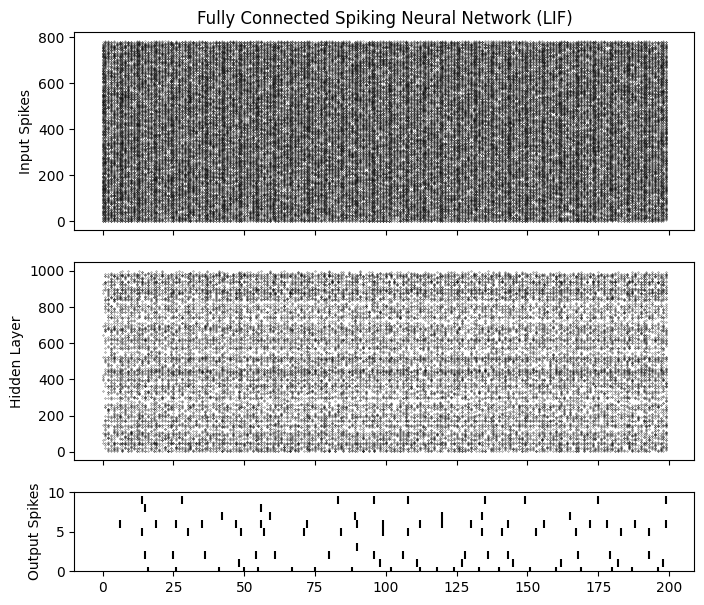

In [5]:
# Layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# Initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = Leaky(beta=beta)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# Record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Create an input spike train to pass to the network. 
# There are 200 timesteps to simulate across 784 input neurons.
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

# Network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network (LIF)")

### Then do the same thing with our custom `Funky` neurons

Dimensions of spk_in: torch.Size([200, 1, 784])


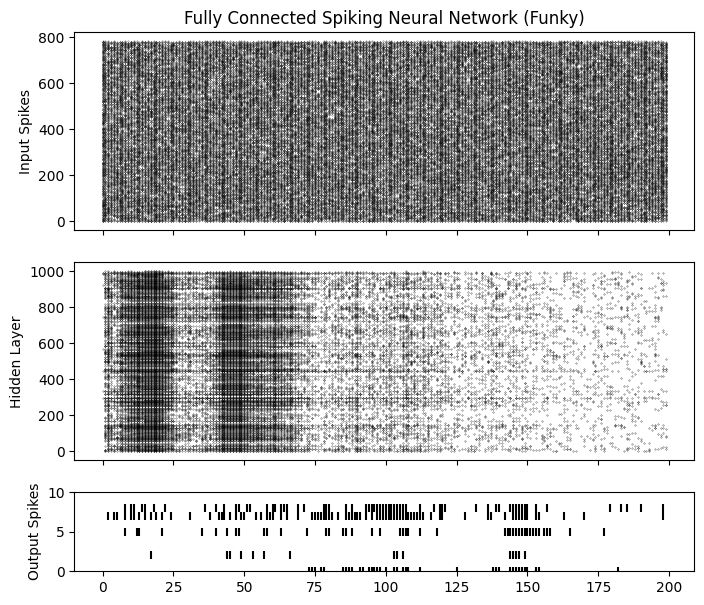

In [6]:
# Layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# Initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
funky1 = Funky(beta=beta, funkiness=0.2)
fc2 = nn.Linear(num_hidden, num_outputs)
funky2 = Funky(beta=beta, funkiness=0.2)

# Initialize hidden states
mem1 = funky1.init_funky()
mem2 = funky2.init_funky()

# Record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Create an input spike train to pass to the network. 
# There are 200 timesteps to simulate across 784 input neurons.
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

# Network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = funky1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = funky2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network (Funky)")

At this stage, the spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But the spikes appear to be propagating from the first layer through to the output. 

For the `Funky` neurons, we get significantly more variation in activity - some neurons (presumably those whose thresholds have been decreased) fire a lot of spikes, while others fire very rarely.

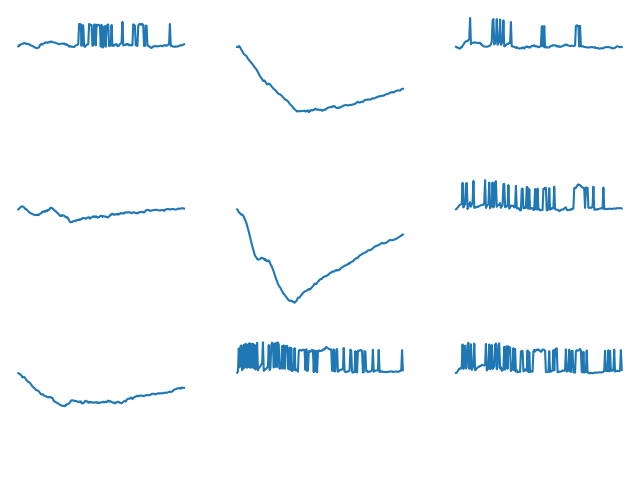

In [8]:
# Plot membrane potential traces for 9 of the 10 output neurons
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)

Some neurons are firing while others are completely dead. (Again, none of these spikes have any real meaning until the weights have been trained.)

# Training the network

Adapted from snnTorch Tutorial 5

In [3]:
# Define functions to compute accuracy
# (pass data into the network, sum the spikes over time and compare the neuron with the highest number of spikes with the target)

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

### Train a network of `Funky` neurons on the MNIST dataset

In [ ]:
from snntorch._neurons import Funky
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

num_inputs = 28*28
num_hidden = 1000
num_outputs = 10
num_steps = 25
beta = 0.95

## Define funky network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers using funky neuron
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.funky1 = Funky(beta=beta, funkiness=0.1)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.funky2 = Funky(beta=beta, funkiness=0.1)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.funky1.init_funky()
        mem2 = self.funky2.init_funky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.funky1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.funky2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net()

batch_size = 128
data_path='/tmp/data/mnist'
dtype = torch.float
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
data, targets = next(iter(train_loader))

# Training loop
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

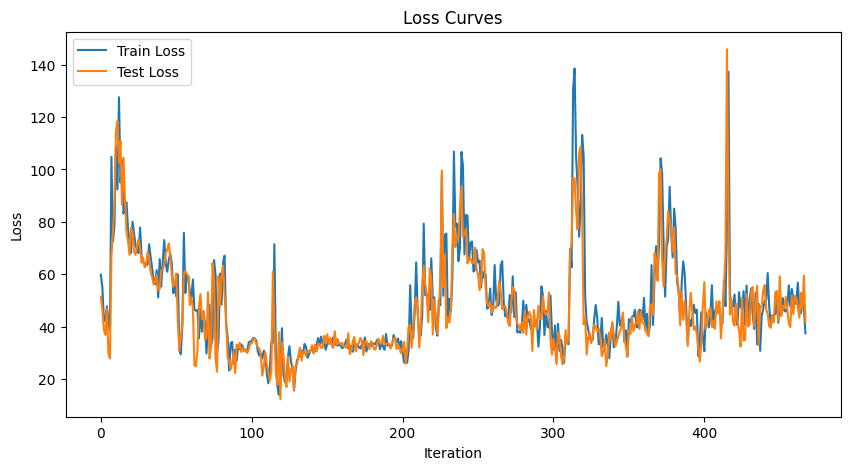

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


Unlike what we would expect for a network of `Leaky` neurons, the loss for the network of `Funky` neurons does not continuously decrease. This is an indication that the `funkiness` parameter is too high, and the network has become unstable. 

Due to this stochasticity, re-training the network with different levels of `funkiness` (or even multiple times without changing any parameters) can lead to very different results.

In [ ]:
# Evaluate the network on the test set
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 8643/10000
Test Set Accuracy: 86.43%


# Funkiness vs accuracy

Let's evaluate how robust our SNN is by increasing the `funkiness` from 0 to 0.1, and measuring average test set accuracy for each `funkiness` level.

In [ ]:
from snntorch._neurons import Funky
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

funkiness_list = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

num_inputs = 28*28
num_hidden = 1000
num_outputs = 10
num_steps = 25
beta = 0.95

overall_accuracies = []
for funkiness in funkiness_list:
    
    accuracies = []
    for repeat in range(10):

        ## Define funky network
        class Net(nn.Module):
            def __init__(self):
                super().__init__()

                # Initialize layers using funky neuron
                self.fc1 = nn.Linear(num_inputs, num_hidden)
                self.funky1 = Funky(beta=beta, funkiness=funkiness)
                self.fc2 = nn.Linear(num_hidden, num_outputs)
                self.funky2 = Funky(beta=beta, funkiness=funkiness)

            def forward(self, x):
                mem1 = self.funky1.init_funky()
                mem2 = self.funky2.init_funky()
                spk2_rec = []
                mem2_rec = []

                for step in range(num_steps):
                    cur1 = self.fc1(x)
                    spk1, mem1 = self.funky1(cur1, mem1)
                    cur2 = self.fc2(spk1)
                    spk2, mem2 = self.funky2(cur2, mem2)
                    spk2_rec.append(spk2)
                    mem2_rec.append(mem2)
                return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

        net = Net()

        batch_size = 128
        data_path='/tmp/data/mnist'
        dtype = torch.float
        transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))])
        mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
        mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
        test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
        data, targets = next(iter(train_loader))

        # Training
        num_epochs = 1
        for epoch in range(num_epochs):
            iter_counter = 0
            train_batch = iter(train_loader)

            for data, targets in train_batch:
                net.train()
                spk_rec, mem_rec = net(data.view(batch_size, -1))

                loss_val = torch.zeros((1), dtype=dtype)
                for step in range(num_steps):
                    loss_val += loss(mem_rec[step], targets)

                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

        # Accuracy
        total = 0
        correct = 0
        test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)
        with torch.no_grad():
            net.eval()
            for data, targets in test_loader:
                test_spk, _ = net(data.view(data.size(0), -1))
                _, predicted = test_spk.sum(dim=0).max(1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        print(f"Funkiness: {funkiness}")
        print(f"Total correctly classified test set images: {correct}/{total}")
        print(f"Test Set Accuracy: {accuracy:.2f}%")

        accuracies.append(accuracy)
    print(accuracies)
    overall_accuracies.append(accuracies)


Funkiness: 0
Total correctly classified test set images: 9444/10000
Test Set Accuracy: 94.44%
Funkiness: 0
Total correctly classified test set images: 9275/10000
Test Set Accuracy: 92.75%
Funkiness: 0
Total correctly classified test set images: 9385/10000
Test Set Accuracy: 93.85%
Funkiness: 0
Total correctly classified test set images: 9467/10000
Test Set Accuracy: 94.67%
Funkiness: 0
Total correctly classified test set images: 9456/10000
Test Set Accuracy: 94.56%
Funkiness: 0
Total correctly classified test set images: 9278/10000
Test Set Accuracy: 92.78%
Funkiness: 0
Total correctly classified test set images: 9323/10000
Test Set Accuracy: 93.23%
Funkiness: 0
Total correctly classified test set images: 9438/10000
Test Set Accuracy: 94.38%
Funkiness: 0
Total correctly classified test set images: 9527/10000
Test Set Accuracy: 95.27%
Funkiness: 0
Total correctly classified test set images: 9284/10000
Test Set Accuracy: 92.84%
[94.44, 92.75, 93.85, 94.67, 94.56, 92.78, 93.23, 94.38, 95.

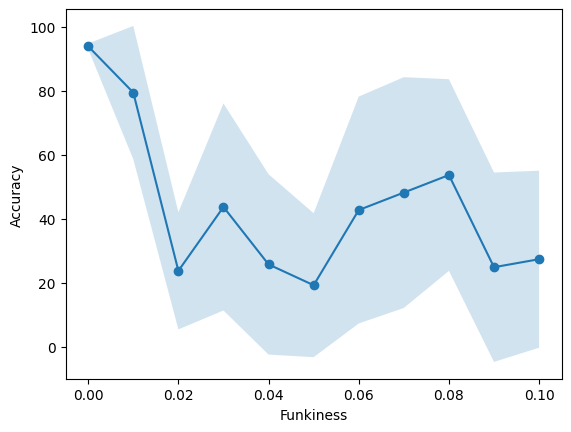

In [ ]:
# Copied output from above for visualization and plotting without needing to re-run training and testing
funkiness_list = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
overall_accuracies = [[94.44, 92.75, 93.85, 94.67, 94.56, 92.78, 93.23, 94.38, 95.27, 92.84],
[93.04, 94.98, 92.19, 78.62, 93.09, 82.55, 90.51, 64.42, 81.87, 22.84],
[21.5, 9.8, 35.92, 20.97, 18.5, 73.2, 12.09, 9.8, 9.8, 25.18],
[91.8, 71.47, 9.97, 88.49, 67.48, 9.8, 9.8, 29.05, 9.8, 48.77],
[75.04, 9.81, 9.8, 25.88, 10.09, 87.02, 9.8, 9.8, 9.8, 9.8],
[19.04, 10.68, 9.8, 10.34, 9.8, 9.81, 11.09, 10.01, 86.14, 15.07],
[10.54, 74.39, 9.84, 19.04, 89.26, 26.2, 9.8, 86.11, 9.8, 91.87],
[15.84, 10.1, 19.34, 62.61, 90.75, 9.82, 9.8, 83.38, 88.38, 91.45],
[80.16, 9.8, 84.91, 85.96, 44.31, 88.58, 12.55, 55.03, 17.35, 57.6],
[9.8, 9.8, 11.26, 9.8, 9.99, 84.82, 83.22, 9.8, 9.75, 9.8],
[87.78, 9.8, 27.55, 9.8, 73.8, 9.8, 9.8, 9.8, 9.91, 25.08]]

# Calculate mean and std for funkiness
means = [np.mean(acc) for acc in overall_accuracies]
stds = [np.std(acc) for acc in overall_accuracies]

# Plot mean as a line with shaded area for standard deviation
plt.plot(funkiness_list, means, marker='o')
plt.fill_between(funkiness_list,[m-s for m, s in zip(means, stds)], [m+s for m, s in zip(means, stds)], alpha=0.2)
plt.xlabel('Funkiness')
plt.ylabel('Accuracy')
plt.show()

Unsurprisingly, when `funkiness=0.0` (no spike threshold modification, Funky neuron is equivalent to a standard LIF), the network performs very well (~94% accuracy with very little variation between runs).

The network also performs fairly well at `funkiness=0.01`, but once funkiness is increased to `0.02` and beyond, the network becomes unstable.

Interestingly, gradually increasing funkiness from `0.02` to `0.10` does not cause further performance degradation. With larger threshold modifications on each spike, the network is more likely to be perturbed out of the stable equilibrium in which it has learned representations of each MNIST digit. However, these large threshold modifcations may also make the network more able to recover and escape local minima, which may explain why performance does not continue to decrease as funkiness increases past `0.02`.

In a future exploration, it would be interesting to use the funkiness parameter to optimize learning, mirroring annealing strategies used in machine learning to balance exploration and exploitation. An optimal strategy might initially set funkiness to a very low value (<0.01), allowing the network to learn basic representations of each digit without excessive randomness. Increasing the funkiness as training progresses would then encourage exploration and prevent overfitting to specific neurons or patterns. Finally, decreasing funkiness towards the end of training would help the model converge onto the optimal solution.